In [1]:
import numpy as np
import cv2
import torch
import pandas as pd
import re
import pickle as pkl
import json
import glob
import shutil
import os
import json
import pathlib as pl
from typing import List, Tuple, Dict, Union, Optional
from tqdm import trange, tqdm
from glob import glob
from collections import Counter
from sklearn.model_selection import train_test_split

from modules.preprocessing import V2XPreprocessing
from modules.v2x import V2XData,V2XDataLabeled
from modules.metrics import *
from tsai.all import *
from tqdm import tqdm
from modules.RunTSAI import RunTSAI
from sklearn.utils import shuffle


## 10월

Counter({'Fals': 1273760, 'Righ': 38146, 'Left': 35737, 'Reve': 2357})
Counter({'Fals': 1350000})
Counter({'Fals': 1348931, 'Hbrk': 800, 'Acc': 269})
Counter({'Fals': 1345491, 'True': 4509})


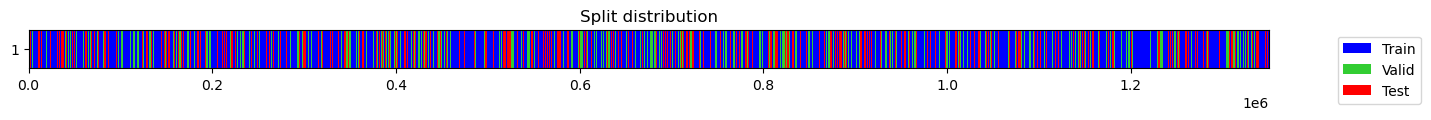

In [22]:
config = AttrDict(
    batch_tfms = TSStandardize(),
    architecture = LSTM, # LSTM, LSTM_FCNPlus, MLSTM_Plus
    n_epochs = 10,
)

X = np.load("pickles/10월/X_10.npy")
y = np.load("pickles/10월/y_10.npy")
RunTSAI.target_label_counter(y)
splits = get_splits(X, shuffle=True, valid_size=0.2, test_size=0.2, random_state=42)
y10_hazard = y[:, 3]

In [19]:
def binary_classification(X, y, split, config, save_path=None):
    tfms = [None, None]
    dsets = TSDatasets(X, y, tfms=tfms, splits=split, inplace=True)
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=128, 
                                    batch_tfms=config["batch_tfms"], num_workers=0)
    model = create_model(config["architecture"], dls=dls)
    learn = Learner(dls, model, metrics=[accuracy, F1Score(average='macro'), Precision(average='macro'), Recall(average='macro')], loss_func=BCEWithLogitsLossFlat())

    # Train model
    learn.fit_one_cycle(config["n_epochs"], )
    learn.recorder.plot_metrics()
    
    # is save
    if save_path:
        learn.save_all(save_path)
    return learn

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,0.023002,0.022667,0.996596,0.499148,0.498298,0.500000,04:02
1,0.025791,0.022721,0.996596,0.499148,0.498298,0.500000,03:50
2,0.021214,0.022662,0.996596,0.499148,0.498298,0.500000,04:04
3,0.020253,0.022602,0.996596,0.499148,0.498298,0.500000,03:54
4,0.020696,0.022626,0.996596,0.499148,0.498298,0.500000,03:18
5,0.027741,0.022534,0.996596,0.499148,0.498298,0.500000,02:54
6,0.019891,0.022502,0.996596,0.499148,0.498298,0.500000,02:16
7,0.022053,0.022512,0.996596,0.499148,0.498298,0.500000,02:12
8,0.012980,0.022513,0.996596,0.499148,0.498298,0.500000,02:45
9,0.016336,0.022492,0.996596,0.499148,0.498298,0.500000,03:01


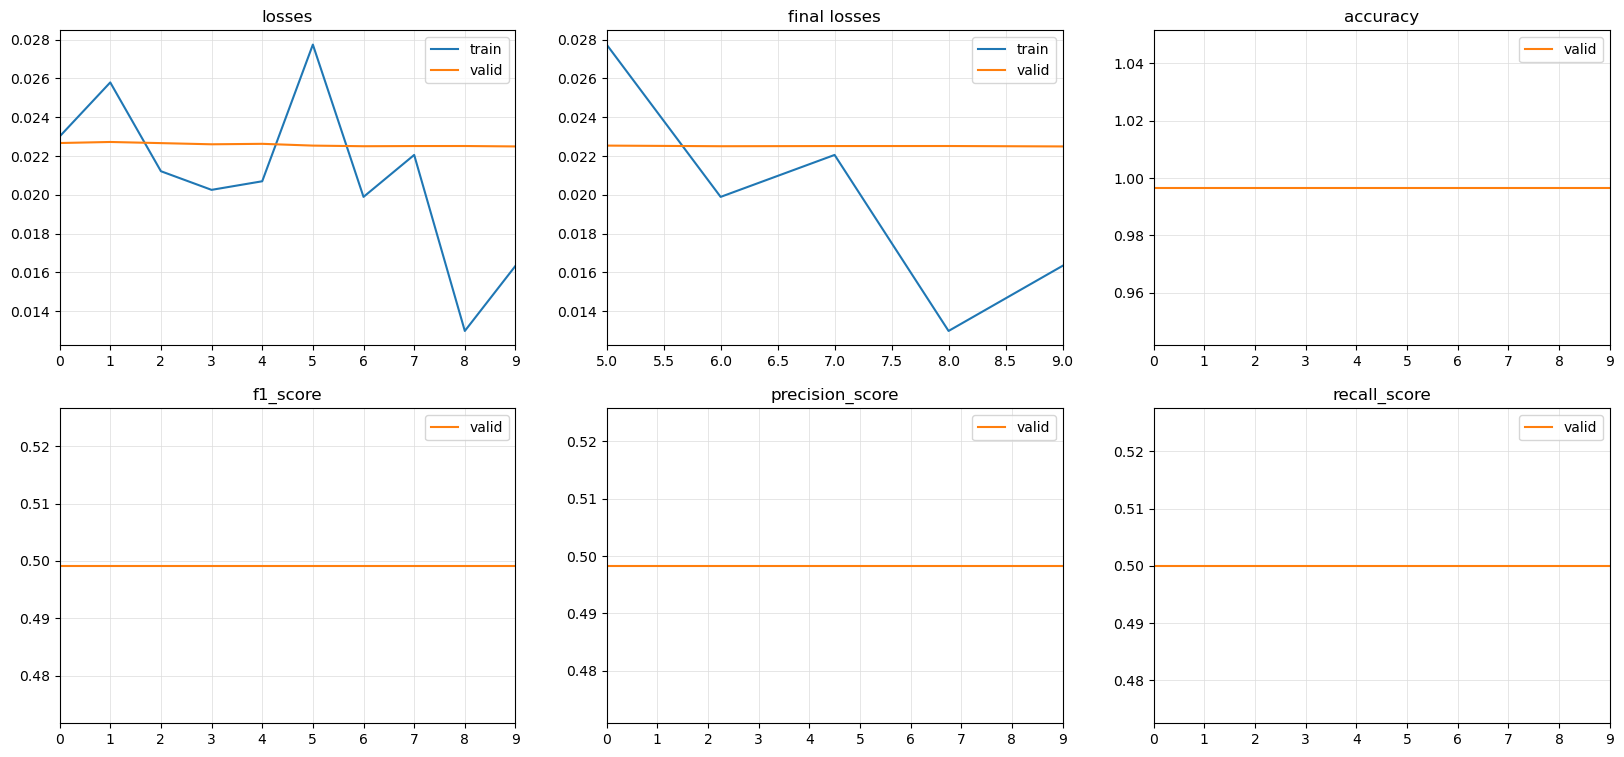

In [24]:
batch_tfms = TSStandardize()
learn10_hazard = TSClassifier(X, y10_hazard, splits=splits, path='models', arch=LSTM, batch_tfms=batch_tfms, cbs=ShowGraph(), metrics=[accuracy, F1Score(average='macro'), Precision(average='macro'), Recall(average='macro')])
learn10_hazard.fit_one_cycle(10, 3e-4)